📊 Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5787
           1       1.00      0.67      0.80         3

    accuracy                           1.00      5790
   macro avg       1.00      0.83      0.90      5790
weighted avg       1.00      1.00      1.00      5790



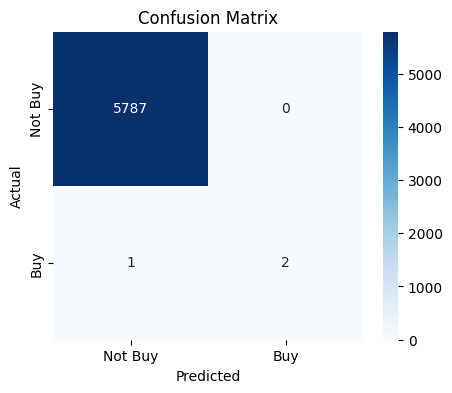

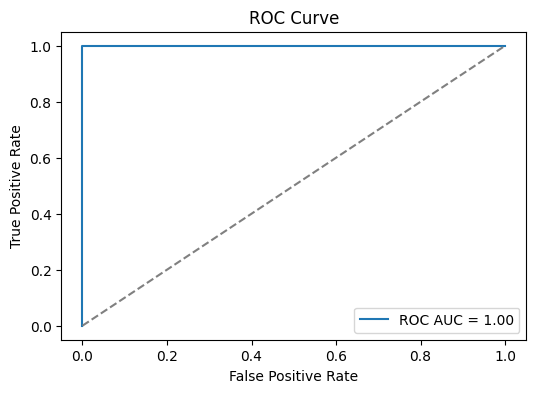

In [3]:
# --- Step 1: Imports ---
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 2: Load Dataset ---
df = pd.read_csv("/content/drive/MyDrive/algo_trading_project/data/nifty50_features.csv", parse_dates=["Date"])

# --- Step 3: Add Extra Features ---
df["MACD_Histogram"] = df["MACD"] - df["MACD_Signal"]
df["Daily_Return"] = df["Close"].pct_change()
df["Volatility_5"] = df["Daily_Return"].rolling(window=5).std()
df["Momentum_10"] = df["Close"] / df["Close"].shift(10)

# --- Step 4: Create Binary Buy Signal ---
def label_buy_signals(row):
    return 1 if (row["MACD"] > row["MACD_Signal"]) and (row["RSI"] < 30) else 0

df["Buy_Signal"] = df.apply(label_buy_signals, axis=1)

# --- Step 5: Drop NaNs after all engineering ---
df.dropna(inplace=True)

# --- Step 6: Features and Target ---
features = [
    "MACD", "MACD_Signal", "MACD_Histogram",
    "RSI", "SMA_20", "EMA_20",
    "Volatility_5", "Momentum_10",
    "Volume"
]
X = df[features]
y = df["Buy_Signal"]

# --- Step 7: Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# --- Step 8: SMOTE for Class Imbalance ---
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# --- Step 9: Train Random Forest ---
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_res, y_train_res)

# --- Step 10: Evaluate Model ---
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("📊 Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Buy", "Buy"], yticklabels=["Not Buy", "Buy"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, y_prob):.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


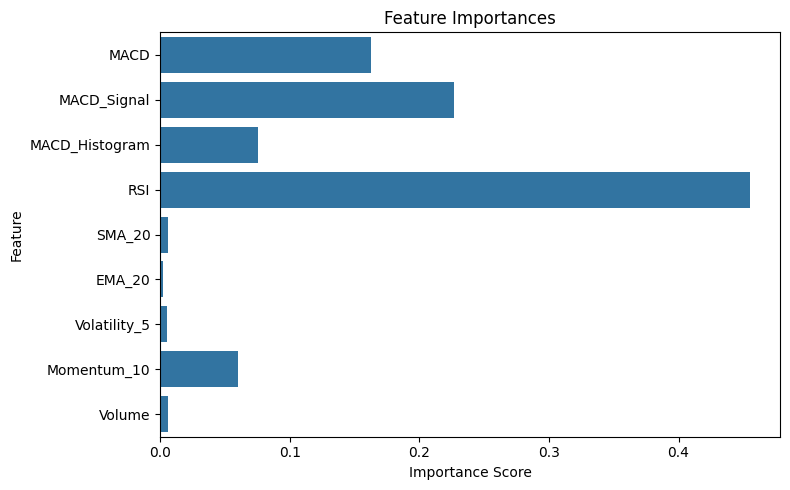

In [4]:
importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
